In [4]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
import numpy as np
import pprint

# Qiskit imports
# from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="DIN NYCKEL HÄR",overwrite = True)
service = QiskitRuntimeService()



In [5]:
num_qubits =11
# backend = service.least_busy(operational=True, simulator=False, min_num_qubits=num_qubits)
backend_name = "ibm_brussels"
backend = service.backend(backend_name)
backend

<IBMBackend('ibm_brussels')>

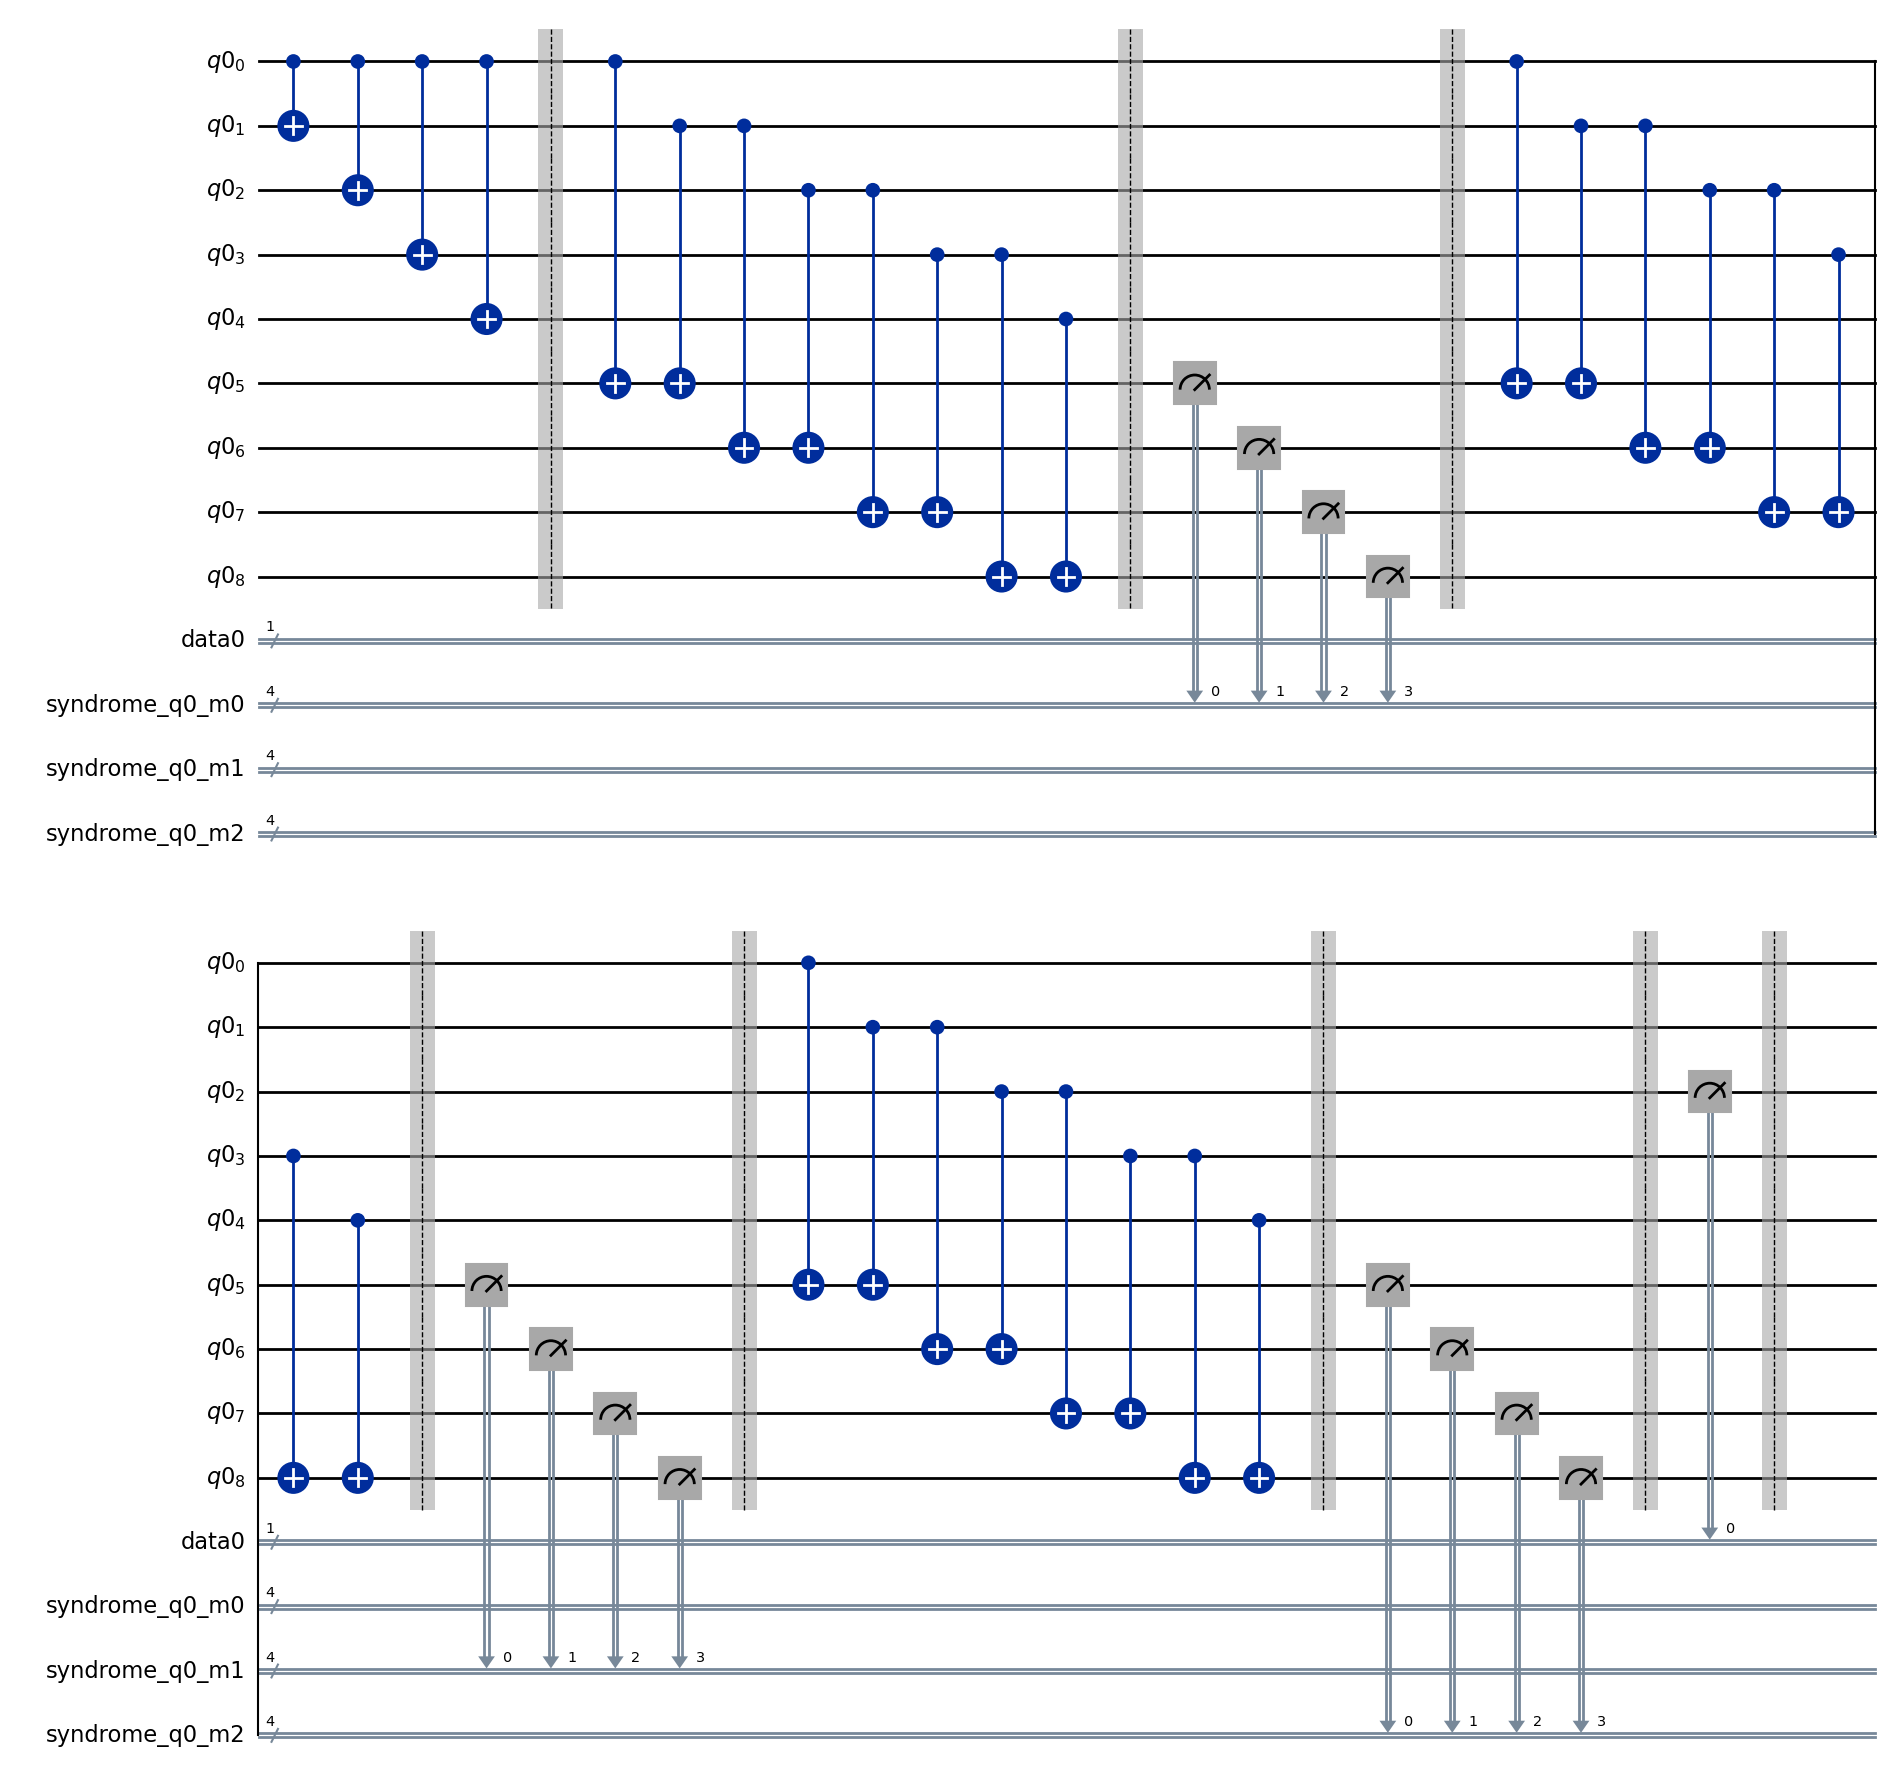

In [6]:

def gen_circuit(k=1, d=3, n_measure = 1):

    # qubits ordered by logical qubit
    qreg_q = [QuantumRegister(2*d-1, f"q{i}") for i in range(k)]

    # Data register ordered by logical qubit
    creg_data = [ClassicalRegister(1, f"data{i}") for i in range(k)]

    # Syndrome register ordered by logical qubit with capacity for multiple measurements
    creg_syndromes = sum([[ClassicalRegister((d-1), f"syndrome_q{i}_m{m}") for m in range(n_measure+1)] for i in range(k)],[])

    # print(creg_syndromes)
    # print(creg_data)

    circuit = QuantumCircuit(*qreg_q, *creg_data, *creg_syndromes)


    for i in range(k):

        # Entangle redundancy qubits
        for j in range(1,d):
            circuit.cx(qreg_q[i][0], qreg_q[i][j])

        # circuit.barrier(qreg_q[i][0], qreg_q[i][1], qreg_q[i][2], qreg_q[i][3], qreg_q[i][4])
        circuit.barrier([qreg_q[i][j] for j in range(2*d-1)])

        for m in range(n_measure):
            # Stabilizer computation
            for j in range(d-1):
                circuit.cx(qreg_q[i][j], qreg_q[i][d+j])
                circuit.cx(qreg_q[i][j+1], qreg_q[i][d+j])

            # circuit.barrier(qreg_q[i][0], qreg_q[i][1], qreg_q[i][2], qreg_q[i][3], qreg_q[i][4])
            circuit.barrier([qreg_q[i][j] for j in range(2*d-1)])

            # Measure syndrome
            for j in range(d-1):
                circuit.measure(qreg_q[i][j+d], creg_syndromes[i*n_measure+m][j])

        
            circuit.barrier([qreg_q[i][j] for j in range(2*d-1)])

        for i in range(d - 1):             # Syndrom
            circuit.cx(qreg_q[0][i], qreg_q[0][d+i])     
            circuit.cx(qreg_q[0][i + 1], qreg_q[0][d+i])
        circuit.barrier()
        circuit.measure(qreg_q[0][d:], creg_syndromes[n_measure])
        circuit.barrier()
        circuit.measure(qreg_q[0][d//2], creg_data[0])
        circuit.barrier()
        return circuit
    
        # circuit.measure(qreg_q[1], creg_data[1])
        # circuit.measure(qreg_q[2], creg_data[2])

    return circuit



logic_qubits = 1
qubits_per_logical = 5
number_of_measurements = 2


circuit = gen_circuit(logic_qubits,qubits_per_logical,number_of_measurements)

circuit.draw(output="mpl", style='iqp')




In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

#isa_circuit.draw('mpl', style='iqp', idle_wires=False)

In [8]:
sampler = Sampler(backend)
shots = 100
job = sampler.run([isa_circuit], shots=shots)


In [9]:
result= job.result()[0]

In [32]:
def reconstruct_left(syndromes, boundary_value):
   
    if not syndromes: # Basecase
        return []
    
    last_value = boundary_value ^ int(syndromes[-1]) # Jämnför syndrom
    
    return reconstruct_left(syndromes[:-1], last_value) + [last_value]

def reconstruct_right(syndromes, boundary_value):
  
    if not syndromes: # Basecase
        return []
    
    first_value = boundary_value ^ int(syndromes[0]) # Jämnför syndrom
    
    return [first_value] + reconstruct_right(syndromes[1:], first_value)

def reconstruct_logical_qubit(syndromes, measured_middle):
   
    d = len(syndromes) + 1
    mid = d // 2  # Mitten av listan
    
    left_syndromes = syndromes[:mid]      # Vänstra delen
    right_syndromes = syndromes[mid:]        # Högra delen
    
    left_side = reconstruct_left(left_syndromes, measured_middle)
    right_side = reconstruct_right(right_syndromes, measured_middle)
    
    # return hela resultatet
    return left_side + [measured_middle] + right_side


In [33]:
def process_results(result, shots, repetition, num_shots):
 
    syndromes_data = []
    finalstate_data = []
    
    # syndrom
    syndrome_attr = getattr(result.data, f"syndrome_q0_m{repetition-1}")
    
    # Tar fram all data
    for i in range(shots):
        syndromes_data.append(syndrome_attr.get_counts(i))
        finalstate_data.append(result.data.data0.get_counts(i))
    
    
    syndrome_list = [list(item.keys())[0] for item in syndromes_data]
    finalstate_list = [list(item.keys())[0] for item in finalstate_data]
    
    
    for i in range(min(num_shots, len(syndrome_list))):
        # Tillståndet i mittersta kvantbiten
        final_str = finalstate_list[i]
        measured_middle = int(final_str[0])
        
        # Använd det uppmätta kvantbitstillståndet för att beräkna den logiska kvanttilståndet
        reconstructed_state = reconstruct_logical_qubit(syndrome_list[i], measured_middle)
        print(f"Shot {i}: Logical Qubit State: {reconstructed_state}")




In [ ]:

# Tar fram data för jämförelse
syndromes_3 = []
finalstate = []
shots  = 100
for i in range(shots-1):
    syndromes_3.append(result.data.syndrome_q0_m2.get_counts(i))
    finalstate.append(result.data.data0.get_counts(i))

syndrome_list_3 = [(list(item.keys())[0]) for item in syndromes_3]
finalstate_list = [list(item.keys())[0] for item in finalstate]
print(syndrome_list_3[0:11])
final_state =  [int(m[0]) for m in finalstate_list]
print(final_state[0:11])

['1001', '1100', '0000', '0001', '0000', '0000', '0110', '0000', '0000', '1110', '0110']
[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1]


In [ ]:
repetitions = 2+1 # num_repetitions + Sista mätningen
count = 11
process_results(result, shots, repetitions, count) # (Resultat av körning, shots, repetitions+1, hur många data punkter man vill ha)

Shot 0: Logical Qubit State: [0, 1, 1, 1, 0]
Shot 1: Logical Qubit State: [0, 1, 0, 0, 0]
Shot 2: Logical Qubit State: [0, 0, 0, 0, 0]
Shot 3: Logical Qubit State: [0, 0, 0, 0, 1]
Shot 4: Logical Qubit State: [0, 0, 0, 0, 0]
Shot 5: Logical Qubit State: [1, 1, 1, 1, 1]
Shot 6: Logical Qubit State: [0, 0, 1, 0, 0]
Shot 7: Logical Qubit State: [0, 0, 0, 0, 0]
Shot 8: Logical Qubit State: [0, 0, 0, 0, 0]
Shot 9: Logical Qubit State: [1, 0, 1, 0, 0]
Shot 10: Logical Qubit State: [0, 0, 1, 0, 0]
